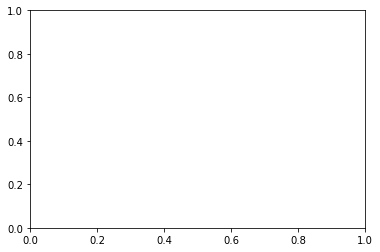

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py, os, copy
from skimage import exposure
import numpy.ma as ma
import pandas

def aop_h5refl2array(refl_filename):
    
    #Read in reflectance hdf5 file 
    hdf5_file = h5py.File(refl_filename,'r')

    #Get the site name
    file_attrs_string = str(list(hdf5_file.items()))
    file_attrs_string_split = file_attrs_string.split("'")
    sitename = file_attrs_string_split[1]
    
    #Extract the reflectance & wavelength datasets
    refl = hdf5_file[sitename]['Reflectance']
    reflData = refl['Reflectance_Data']
    reflRaw = refl['Reflectance_Data'][()]
    
    #Apply no data value
    reflClean = reflRaw.astype(float)

    hdf5_file.close
    
    return reflClean

def plot_aop_refl(band_array,colorlimit=(0,1),ax=plt.gca(),title='',cbar ='on',cmap_title='',colormap='Greys'):
    plot = plt.imshow(band_array,clim=colorlimit); 
    if cbar == 'on':
        cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
        cbar.set_label(cmap_title,rotation=90,labelpad=20)
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain'); #do not use scientific notation for ticklabels
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90); #rotate x tick labels 90 degrees
    
def stack_rgb(reflArray,bands):
    red = reflArray[:,:,bands[0]-1]
    green = reflArray[:,:,bands[1]-1]
    blue = reflArray[:,:,bands[2]-1]
    
    stackedRGB = np.stack((red,green,blue),axis=2)
    
    return stackedRGB

def plot_aop_rgb(rgbArray,ext,ls_pct=5,plot_title=''):
    pLow, pHigh = np.percentile(rgbArray[~np.isnan(rgbArray)], (ls_pct,100-ls_pct))
    img_rescale = exposure.rescale_intensity(rgbArray, in_range=(pLow,pHigh))
    plt.imshow(img_rescale,extent=ext)
    plt.title(plot_title + '\n Linear ' + str(ls_pct) + '% Contrast Stretch'); 
    ax = plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degree

In [2]:
from skimage.io import imread
im = imread("L1C_T44PMC_A020594_20210214T051145.tif")  # a sample image
f = h5py.File("myfile.hdf5", 'a')
out = f.require_dataset('/x', shape=(1, 5490, 5490, 3), dtype=im.dtype)

In [3]:
sercRefl = aop_h5refl2array("NEON_D02_SERC_DP3_368000_4306000_reflectance.h5") 

In [13]:
vis = sercRefl[:,:,40]
nir = sercRefl[:,:,100]

ndwi = np.divide((nir-vis),(nir+vis))

TypeError: Invalid shape (1000, 1000, 426) for image data

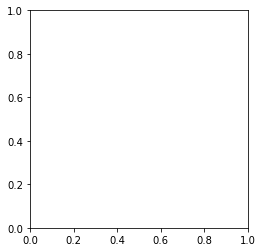

In [24]:
plt.imshow(sercRefl[:,:,:])

In [6]:
ndwi_gtpt6 = copy.copy(ndwi)
#set all pixels with NDVI < 0.6 to nan, keeping only values > 0.6
ndwi_gtpt6[ndwi>0.4] = np.nan  
print('Mean NDVI > 0.6:',round(np.nanmean(ndwi_gtpt6),2))

Mean NDVI > 0.6: -0.17


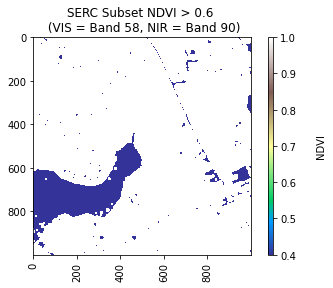

In [7]:
plot_aop_refl(ndwi_gtpt6,
                colorlimit=(0.4,1),
                title='SERC Subset NDVI > 0.6 \n (VIS = Band 58, NIR = Band 90)',
                cmap_title='NDVI',
                colormap='terrain')